In [ ]:
import sys, os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import copy
import warnings
# add the project root to sys.path
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

from data_causl.utils import *
from data_causl.data import *
from frengression import *
import src.exp_utils as exp_utils
device = torch.device('cpu')

warnings.filterwarnings("ignore")


# Continuous X

In [2]:
s, x,z,y= generate_data_longitudinl(n=10000,T=5,C_coeff=1)
# print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)

model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True)

model.train_e(s=s_tr, x=x_tr,z=z_tr,num_iters=3000, lr=1e-4, print_every_iter=1000)
# model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=5000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 2.2187, loss1 2.2615, loss2 0.0856
Epoch 1000: loss 1.1821, loss1 2.3361, loss2 2.3079
Epoch 2000: loss 1.1674, loss1 2.3286, loss2 2.3224
Epoch 3000: loss 1.1772, loss1 2.3395, loss2 2.3246


In [3]:
model.train_e(s=s_tr, x=x_tr,z=z_tr,num_iters=2000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 1.1657, loss1 2.3244, loss2 2.3175
Epoch 1000: loss 1.1765, loss1 2.3320, loss2 2.3111
Epoch 2000: loss 1.1794, loss1 2.3440, loss2 2.3291


In [4]:
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=5000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 6.9187,	loss_y 4.8657, 4.9218, 0.1122,	loss_eta 2.0530, 2.1381, 0.1702
Epoch 1000: loss 2.9693,	loss_y 1.4520, 2.9080, 2.9120,	loss_eta 1.5174, 3.0020, 2.9692
Epoch 2000: loss 2.9611,	loss_y 1.4485, 2.8985, 2.9000,	loss_eta 1.5126, 2.9917, 2.9583
Epoch 3000: loss 2.9514,	loss_y 1.4368, 2.8902, 2.9066,	loss_eta 1.5145, 3.0029, 2.9767
Epoch 4000: loss 2.9386,	loss_y 1.4357, 2.8827, 2.8940,	loss_eta 1.5029, 2.9860, 2.9663
Epoch 5000: loss 2.9416,	loss_y 1.4334, 2.8910, 2.9154,	loss_eta 1.5082, 2.9903, 2.9643


In [5]:
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=5000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 2.9500,	loss_y 1.4364, 2.8859, 2.8990,	loss_eta 1.5135, 2.9877, 2.9483
Epoch 1000: loss 2.9414,	loss_y 1.4365, 2.8851, 2.8971,	loss_eta 1.5048, 2.9804, 2.9512
Epoch 2000: loss 2.9231,	loss_y 1.4267, 2.8665, 2.8796,	loss_eta 1.4964, 2.9650, 2.9372
Epoch 3000: loss 2.9241,	loss_y 1.4120, 2.8525, 2.8810,	loss_eta 1.5121, 2.9857, 2.9472
Epoch 4000: loss 2.9188,	loss_y 1.4082, 2.8469, 2.8774,	loss_eta 1.5106, 2.9766, 2.9321
Epoch 5000: loss 2.9219,	loss_y 1.4127, 2.8404, 2.8554,	loss_eta 1.5092, 2.9814, 2.9445


In [ ]:
y_margin_sample=model.sample_causal_margin(s=torch.tensor([[0]],dtype=torch.float32), 
                                            x = torch.tensor([[1]*5],dtype=torch.int32),
                                            sample_size=1000)

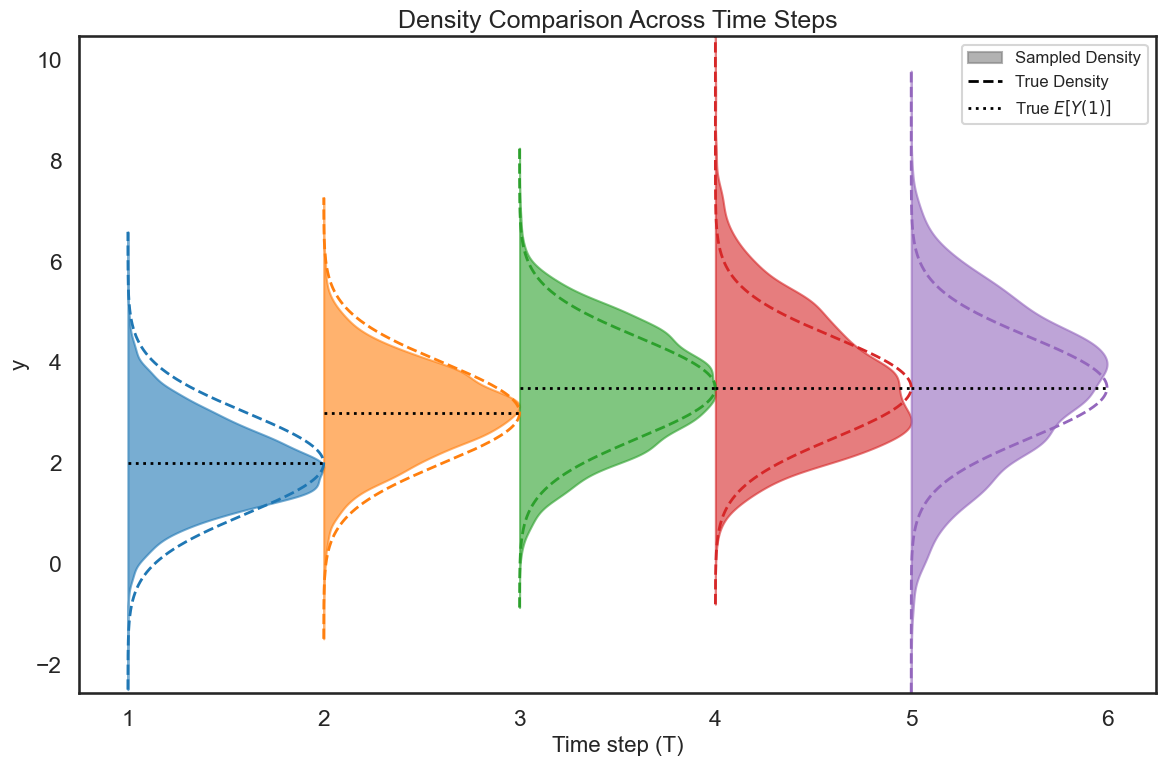

In [9]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values as 1–5
T_values = range(1, 6)

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))

# Initialize the plot
plt.figure(figsize=(12, 8))

for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # KDE of the samples
    kde = gaussian_kde(y)
    y_min, y_max = y.min() - 1, y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    density = kde(y_values)
    density_norm = density / density.max()
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)

    # Choose true density parameters per time step
    if T == 2:
        mu, sigma = 3.0, 1.0
    elif T >= 3:
        mu, sigma = 3.5, 1.0
    else:
        mu, sigma = 2.0, 1.0

    true_density = norm.pdf(y_values, loc=mu, scale=sigma)
    true_density_norm = true_density / true_density.max()
    plt.plot(T + true_density_norm, y_values,
             color=palette[idx], linestyle='--', linewidth=2)

# Segmented horizontal reference lines:
# y=2 for T=1
plt.hlines(2, xmin=1, xmax=2, color='black', linestyle=':', linewidth=2)
# y=3 for T=2–3
plt.hlines(3, xmin=2, xmax=3, color='black', linestyle=':', linewidth=2)
# y=3.5 for T=3–5
plt.hlines(3.5, xmin=3, xmax=4, color='black', linestyle=':', linewidth=2)
plt.hlines(3.5, xmin=4, xmax=5, color='black', linestyle=':', linewidth=2)
plt.hlines(3.5, xmin=5, xmax=6, color='black', linestyle=':', linewidth=2)

# Labels and updated title
plt.xlabel('Time step (T)', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across Time Steps', fontsize=18)

# Updated legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label=r'True $E[Y(1)]$'),
]
plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

plt.tight_layout()
plt.show()


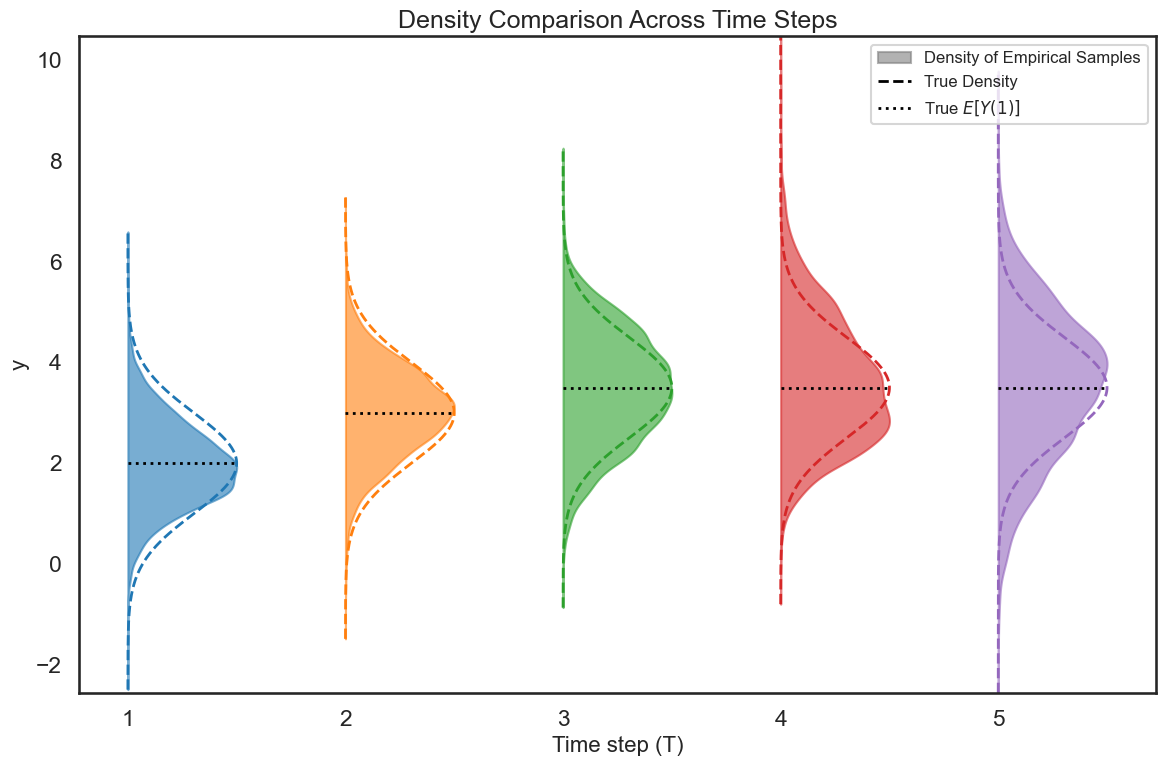

In [10]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values as 1–5
T_values = range(1, 6)

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))

# Initialize the plot
plt.figure(figsize=(12, 8))

for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # KDE of the samples
    kde = gaussian_kde(y)
    y_min, y_max = y.min() - 1, y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    density = kde(y_values)
    density_norm = density / density.max()
    plt.fill_betweenx(y_values, T, density_norm*(0.5) + T, color=palette[idx], alpha=0.6)

    # Choose true density parameters per time step
    if T == 2:
        mu, sigma = 3.0, 1.0
    elif T >= 3:
        mu, sigma = 3.5, 1.0
    else:
        mu, sigma = 2.0, 1.0

    true_density = norm.pdf(y_values, loc=mu, scale=sigma)
    true_density_norm = true_density / true_density.max()
    plt.plot(T + 0.5*true_density_norm, y_values,
             color=palette[idx], linestyle='--', linewidth=2)

# Segmented horizontal reference lines:
# y=2 for T=1
plt.hlines(2, xmin=1, xmax=1.5, color='black', linestyle=':', linewidth=2)
# y=3 for T=2–3
plt.hlines(3, xmin=2, xmax=2.5, color='black', linestyle=':', linewidth=2)
# y=3.5 for T=3–5
plt.hlines(3.5, xmin=3, xmax=3.5, color='black', linestyle=':', linewidth=2)
plt.hlines(3.5, xmin=4, xmax=4.5, color='black', linestyle=':', linewidth=2)
plt.hlines(3.5, xmin=5, xmax=5.5, color='black', linestyle=':', linewidth=2)
# Labels and updated title
plt.xlabel('Time step (T)', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across Time Steps', fontsize=18)

# Updated legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Density of Empirical Samples'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label=r'True $E[Y(1)]$'),
    # Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='y=3 (T=2–3)'),
    # Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='y=3.5 (T=3–5)')
]
plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

plt.tight_layout()
plt.show()
